In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import regex as re
import random
import nltk
import multiprocessing
import umap.umap_ as umap
import umap.plot
import re
import string
import warnings
import torch

from sklearn.metrics import roc_curve, auc, mean_squared_error
from surprise import Reader, Dataset, accuracy
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import cross_validate, KFold, train_test_split
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD

In [2]:
########## Loading Data
device = torch.device('mps' if torch.has_mps else 'cpu')
L = pd.read_csv("Synthetic_Movie_Lens/links.csv")
M = pd.read_csv("Synthetic_Movie_Lens/movies.csv")
R = pd.read_csv("Synthetic_Movie_Lens/ratings.csv")
T = pd.read_csv("Synthetic_Movie_Lens/tags.csv")
print(R.columns)


Index(['Unnamed: 0', 'userId', 'movieId', 'rating', 'timestamp'], dtype='object')


In [3]:
########## Question 1A
possible_ratings = len(set(R['movieId'].values))*len(set(R['userId'].values))
available_ratings = len(R['rating'].values)
sparsity = available_ratings/possible_ratings
print("The sparsity is "+str(sparsity))

The sparsity is 0.016999683055613623


In [4]:
# Group the ratings data by 'movieId'.
grouped = R.groupby('movieId')['rating']

# Get the number of ratings and the variance of ratings for each movie.
rating_counts = grouped.count()
rating_variances = grouped.var()

# Define your subsets.
popular_movies = rating_counts[rating_counts > 2].index
unpopular_movies = rating_counts[rating_counts <= 2].index
high_variance_movies = rating_counts[(rating_counts >= 5) & (rating_variances >= 2)].index

# Trim your ratings data to create the subsets.
popular_ratings = R[R['movieId'].isin(popular_movies)]
unpopular_ratings = R[R['movieId'].isin(unpopular_movies)]
high_variance_ratings = R[R['movieId'].isin(high_variance_movies)]

In [5]:
########## Question 11
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# Convert the relevant columns to numpy arrays.
user_ids = R['userId'].values
movie_ids = R['movieId'].values
ratings = R['rating'].values

# Map each user id to a list of their ratings.
user_ratings = {}
for user_id, rating in zip(user_ids, ratings):
    if user_id not in user_ratings:
        user_ratings[user_id] = []
    user_ratings[user_id].append(rating)

# Map each user id to their average rating.
#average_user_ratings = {user_id: np.mean(ratings) for user_id, ratings in user_ratings.items()}
average_user_ratings = R.groupby('userId')['rating'].mean()
global_average_rating = R['rating'].mean()

# Compute the RMSE for each fold.
kf = KFold(n_splits=10)
rmse_values = []
for train_index, test_index in kf.split(ratings):
    y_true = ratings[test_index]
    y_pred = np.array([average_user_ratings[user_id] for user_id in user_ids[test_index]])
    rmse_values.append(np.sqrt(mean_squared_error(y_true, y_pred)))

# Compute and print the average RMSE.
average_rmse = np.mean(rmse_values)
print("Average RMSE:", average_rmse)

# Define trimming functions
def popular_movies_trim(ratings, indices):
    return indices[ratings['movieId'].loc[indices].map(rating_counts).values > 2]

def unpopular_movies_trim(ratings, indices):
    return indices[ratings['movieId'].loc[indices].map(rating_counts).values <= 2]

def high_variance_movies_trim(ratings, indices):
    indices_var = indices[ratings['movieId'].loc[indices].map(rating_counts).values >= 5]
    return indices_var[ratings['movieId'].loc[indices_var].map(rating_variances) >= 2]

# Define RMSE calculation function
def calculate_rmse(ratings, trim_func):
    kf = KFold(n_splits=10)
    rmse_values = []
    for train_index, test_index in kf.split(ratings):
        test_index = trim_func(ratings, test_index)
        y_true = ratings['rating'].loc[test_index].values
        y_pred = [average_user_ratings.get(user_id, global_average_rating) for user_id in ratings['userId'].loc[test_index]]
        rmse_values.append(mean_squared_error(y_true, y_pred, squared=False))
    return np.mean(rmse_values)

# Compute RMSE for each trimmed subset
print(f"Popular movies RMSE: {calculate_rmse(R, popular_movies_trim)}")
print(f"Unpopular movies RMSE: {calculate_rmse(R, unpopular_movies_trim)}")
print(f"High variance movies RMSE: {calculate_rmse(R, high_variance_movies_trim)}")


Average RMSE: 0.9347086488068349
Popular movies RMSE: 0.9323063150449654
Unpopular movies RMSE: 0.9702092133784082
High variance movies RMSE: 1.3831579898939839


Computing the msd similarity matrix...
Done computing similarity matrix.


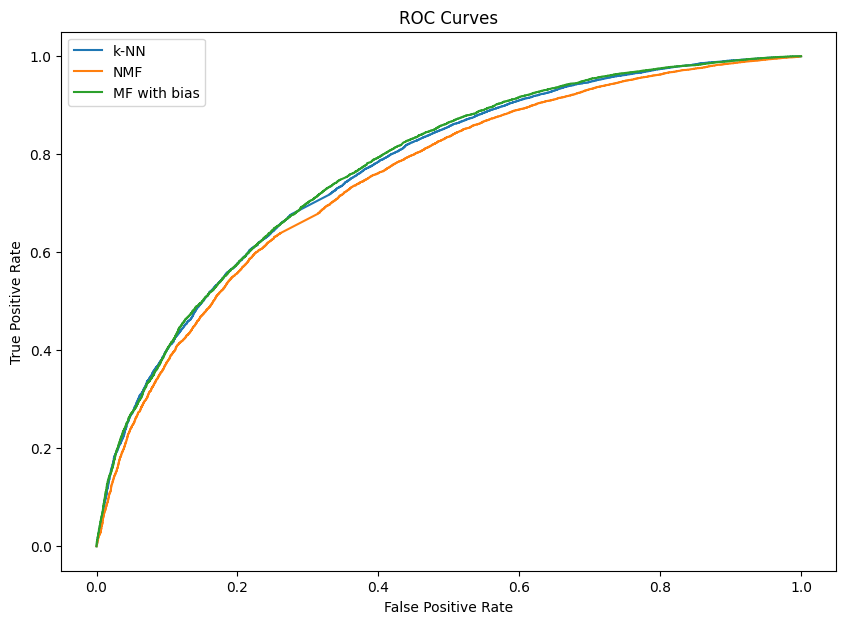

In [6]:
########## Question 12
from surprise import KNNWithMeans, NMF, SVD
from sklearn.metrics import roc_curve, auc

# Reader for surprise library
reader = Reader(rating_scale=(0.5, 5))

# Load your dataset in the surprise dataset format
data = Dataset.load_from_df(R[['userId', 'movieId', 'rating']], reader)

# Train-Test split
trainset, testset = train_test_split(data, test_size=.25)

# Initialize models
knn_model = KNNWithMeans()
nmf_model = NMF()
mf_model = SVD()  # MF with bias

# Train the models
knn_model.fit(trainset)
nmf_model.fit(trainset)
mf_model.fit(trainset)

# Test the models
knn_predictions = knn_model.test(testset)
nmf_predictions = nmf_model.test(testset)
mf_predictions = mf_model.test(testset)

# Binarize the predictions and the true ratings
threshold = 3
knn_y_true = [1 if pred.r_ui > threshold else 0 for pred in knn_predictions]
knn_y_score = [pred.est for pred in knn_predictions]
nmf_y_true = [1 if pred.r_ui > threshold else 0 for pred in nmf_predictions]
nmf_y_score = [pred.est for pred in nmf_predictions]
mf_y_true = [1 if pred.r_ui > threshold else 0 for pred in mf_predictions]
mf_y_score = [pred.est for pred in mf_predictions]

# Compute ROC curve for each model
knn_fpr, knn_tpr, _ = roc_curve(knn_y_true, knn_y_score)
nmf_fpr, nmf_tpr, _ = roc_curve(nmf_y_true, nmf_y_score)
mf_fpr, mf_tpr, _ = roc_curve(mf_y_true, mf_y_score)

# Plot the ROC curves
plt.figure(figsize=(10, 7))
plt.plot(knn_fpr, knn_tpr, label='k-NN')
plt.plot(nmf_fpr, nmf_tpr, label='NMF')
plt.plot(mf_fpr, mf_tpr, label='MF with bias')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

In [7]:
from surprise import KNNWithMeans
from surprise.model_selection import GridSearchCV

# Data loading
reader = Reader(rating_scale=(R.rating.min(), R.rating.max()))
data = Dataset.load_from_df(R[['userId', 'movieId', 'rating']], reader)

# Define parameter grid
param_grid = {'k': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
              'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline'],
                              'user_based': [True, False]}}

# Run grid search
gs_knn = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5)
gs_knn.fit(data)

# Get the best parameters


from surprise import SVD

# Define parameter grid
param_grid = {'n_factors': [50, 100, 150, 200],
              'lr_all': [0.002, 0.005],
              'reg_all': [0.02, 0.1, 0.2]}

# Run grid search
gs_SVD = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
gs_SVD.fit(data)

# Get the best parameters

from surprise import NMF

# Define parameter grid
param_grid = {'n_factors': [10, 15, 20, 50, 100],
              'reg_pu': [0.02, 0.1, 0.2],
              'reg_qi': [0.02, 0.1, 0.2]}

# Run grid search
gs_NMF = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=5)
gs_NMF.fit(data)

# Get the best parameters
print(gs_knn.best_params['rmse'])
print(gs_SVD.best_params['rmse'])
print(gs_NMF.best_params['rmse'])



Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...


In [8]:
print(gs_knn.best_params['rmse'])
print(gs_NMF.best_params['rmse'])
print(gs_SVD.best_params['rmse'])

{'k': 50, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}}
{'n_factors': 100, 'reg_pu': 0.1, 'reg_qi': 0.1}
{'n_factors': 150, 'lr_all': 0.005, 'reg_all': 0.1}


In [9]:
########## Question 13
# Precision and Recall are fundamental measures in information retrieval and they provide insights into the performance of a recommendation system (or any classifier, in general).

# - Precision: It measures how many of the items that we recommended were actually liked by the user. In other words, it's the ratio of correctly recommended items to the total items recommended. A high precision means that an algorithm returned substantially more relevant results than irrelevant ones, i.e., most of the items we recommend are liked by the user.

# - Recall: It measures how many of the liked items were actually recommended. In other words, it's the ratio of correctly recommended items to all items that should have been recommended. A high recall means that an algorithm returned most of the relevant results, i.e., out of all the items the user likes, we managed to recommend a good proportion of them.

# To summarize:

# - If your recommender system has a high precision but low recall, that means it recommends a few items and most of them are liked by the user, but it fails to recommend a lot of other items the user would have liked.
# - If your recommender system has high recall but low precision, it means it recommends many items and the user likes many of them, but it also recommends many items that the user doesn't like.

# In a practical scenario, we need a balance between precision and recall. This balance can be obtained by using measures such as the F1 score, which is the harmonic mean of precision and recall, or by using precision at k (P@k) and average precision, which focus on the quality of the top-k recommendations, which is often what matters in a recommendation system.

Processing KNN
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
t=1: Avg Precision=0.9273987923582607, Avg Recall=0.23107909564397766
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...


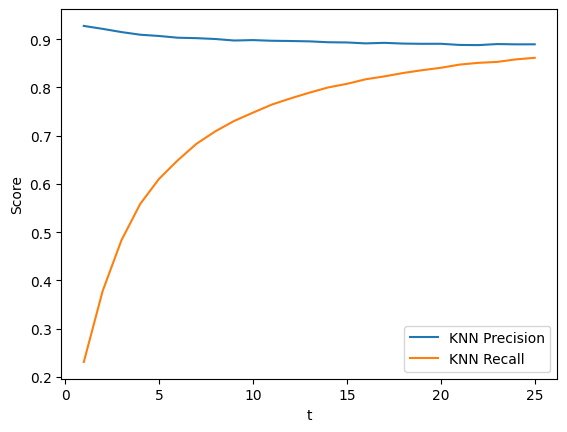

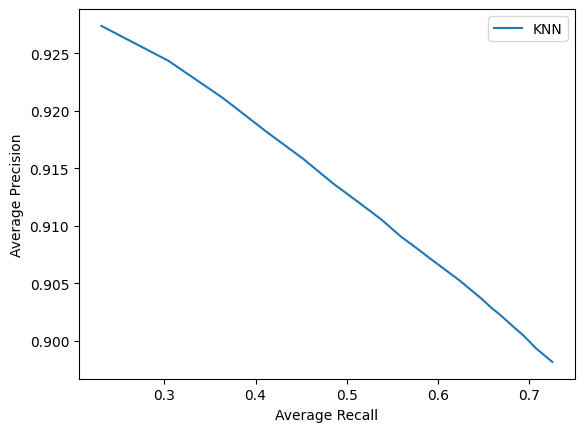

Processing NMF
t=1: Avg Precision=0.9284236504067177, Avg Recall=0.22906133258156602
t=2: Avg Precision=0.9222881169110714, Avg Recall=0.3829888166518111
t=3: Avg Precision=0.9206345882850882, Avg Recall=0.4911439897267427
t=4: Avg Precision=0.9132584026018844, Avg Recall=0.5698591026034018
t=5: Avg Precision=0.905018245294069, Avg Recall=0.6262384091183142
t=6: Avg Precision=0.9060772258974559, Avg Recall=0.6674811960548913
t=7: Avg Precision=0.9011966634085423, Avg Recall=0.7022119643233038
t=8: Avg Precision=0.8999226558339457, Avg Recall=0.7301863461844347
t=9: Avg Precision=0.8976421967265701, Avg Recall=0.7546533927860756
t=10: Avg Precision=0.8959000808339275, Avg Recall=0.7745669906093704
t=11: Avg Precision=0.8965632875550268, Avg Recall=0.7911395961911388
t=12: Avg Precision=0.8938841355582504, Avg Recall=0.8053900487520471
t=13: Avg Precision=0.8929438790810831, Avg Recall=0.8186205284016177
t=14: Avg Precision=0.8939302277634089, Avg Recall=0.8293788806692615
t=15: Avg Prec

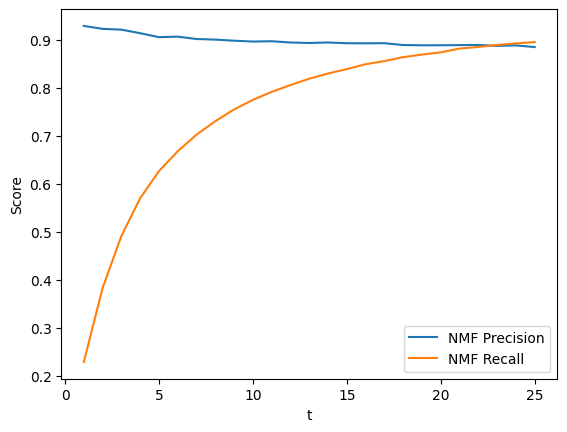

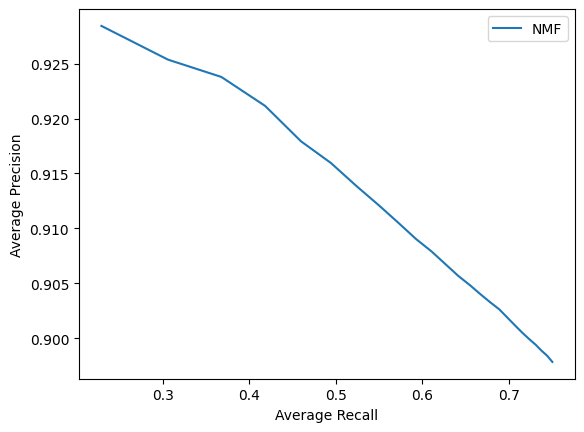

Processing SVD
t=1: Avg Precision=0.934986171024895, Avg Recall=0.22592203819877693
t=2: Avg Precision=0.9282873810721476, Avg Recall=0.369707072393064
t=3: Avg Precision=0.9223708331025552, Avg Recall=0.47567648694085535
t=4: Avg Precision=0.9160102339564664, Avg Recall=0.5477888630465972
t=5: Avg Precision=0.9153776157183824, Avg Recall=0.6013327306801692
t=6: Avg Precision=0.9099887038397242, Avg Recall=0.6431105929996794
t=7: Avg Precision=0.9087536513623264, Avg Recall=0.6742077733797289
t=8: Avg Precision=0.9074291717184051, Avg Recall=0.7007553091901193
t=9: Avg Precision=0.905969018114703, Avg Recall=0.7204752814724401
t=10: Avg Precision=0.9060536224397981, Avg Recall=0.740044684101749
t=11: Avg Precision=0.9024263625289135, Avg Recall=0.7564477296724409
t=12: Avg Precision=0.9036801478559167, Avg Recall=0.7706980587714025
t=13: Avg Precision=0.9015275488984186, Avg Recall=0.7816322590201397
t=14: Avg Precision=0.9011503456592578, Avg Recall=0.7924790428685834
t=15: Avg Precis

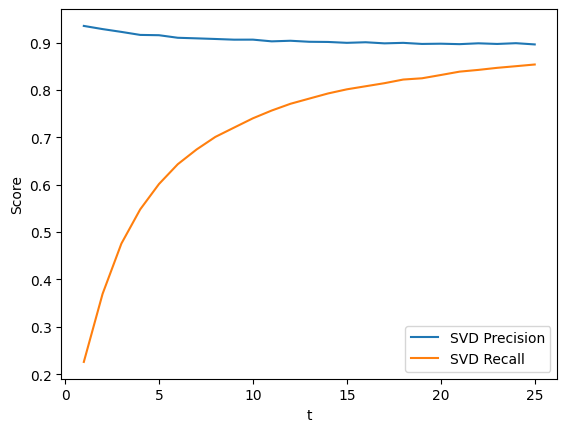

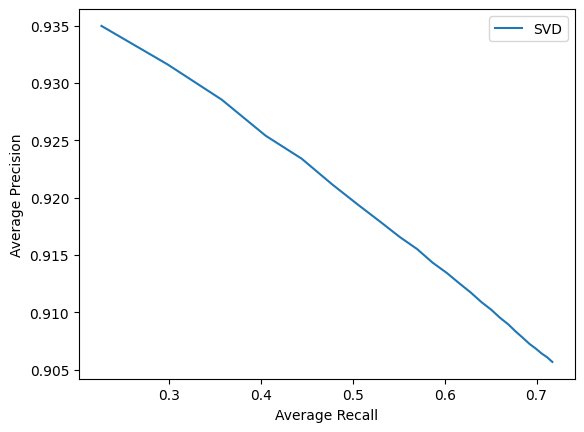

In [10]:
########## Question 14
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls


from collections import defaultdict
from sklearn.metrics import precision_recall_curve, auc
from surprise import KNNBasic, NMF, SVD
from surprise.model_selection import KFold

# Define models
models = {
    'KNN': KNNBasic(k=50),
    'NMF': NMF(n_factors=100),
    'SVD': SVD(n_factors=150)
}

kf = KFold(n_splits=10)

for name, model in models.items():
    print(f"Processing {name}")
    
    precision_list = []
    recall_list = []
    average_precision_list = []
    average_recall_list = []

    for t in range(1, 26):
        precision_values = []
        recall_values = []
        
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset)
            precisions, recalls = precision_recall_at_k(predictions, k=t, threshold=3)
            # Precision and recall are mappings user_id -> float value. You should take the average of these values.
            precision = sum(prec for prec in precisions.values()) / len(precisions)
            recall = sum(rec for rec in recalls.values()) / len(recalls)
            precision_values.append(precision)
            recall_values.append(recall)

        
        avg_precision = np.mean(precision_values)
        avg_recall = np.mean(recall_values)
        precision_list.append(avg_precision)
        recall_list.append(avg_recall)
        
        average_precision_list.append(np.mean(precision_list))
        average_recall_list.append(np.mean(recall_list))
        
        print(f"t={t}: Avg Precision={avg_precision}, Avg Recall={avg_recall}")
    
    plt.plot(range(1, 26), precision_list, label=f'{name} Precision')
    plt.plot(range(1, 26), recall_list, label=f'{name} Recall')
    plt.xlabel('t')
    plt.ylabel('Score')
    plt.legend()
    plt.show()
    
    plt.plot(average_recall_list, average_precision_list, label=f'{name}')
    plt.xlabel('Average Recall')
    plt.ylabel('Average Precision')
    plt.legend()
    plt.show()

Processing KNN
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
t=1: Avg Precision=0.9290164471644383, Avg Recall=0.22915528336578544
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...


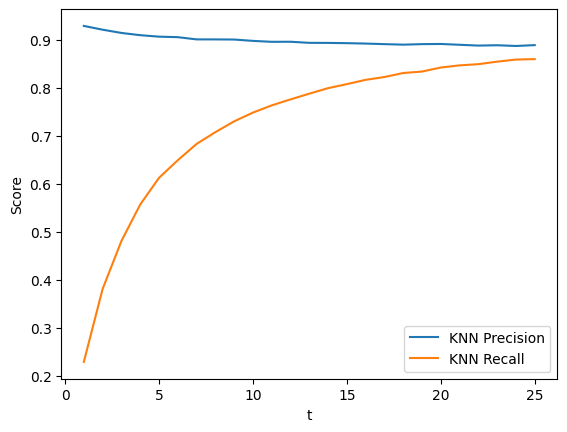

Processing NMF
t=1: Avg Precision=0.9307078444948063, Avg Recall=0.23102582219696005
t=2: Avg Precision=0.9239881340378053, Avg Recall=0.38123478917838316
t=3: Avg Precision=0.9153948787296631, Avg Recall=0.4926276627392897
t=4: Avg Precision=0.9082323873939137, Avg Recall=0.5687240138172734
t=5: Avg Precision=0.9050052277930882, Avg Recall=0.6238785265731537
t=6: Avg Precision=0.904548128924272, Avg Recall=0.6692764185659194
t=7: Avg Precision=0.9031075523040648, Avg Recall=0.7027872493477981
t=8: Avg Precision=0.900041265444465, Avg Recall=0.7331502711672087
t=9: Avg Precision=0.8962965707564464, Avg Recall=0.7544019354483462
t=10: Avg Precision=0.8957441696575824, Avg Recall=0.7726851881454376
t=11: Avg Precision=0.8953116873826875, Avg Recall=0.7929237868055174
t=12: Avg Precision=0.8929212589785045, Avg Recall=0.805968103140609
t=13: Avg Precision=0.890669750638964, Avg Recall=0.8190818544383156
t=14: Avg Precision=0.8928430807346152, Avg Recall=0.828266320816281
t=15: Avg Precisi

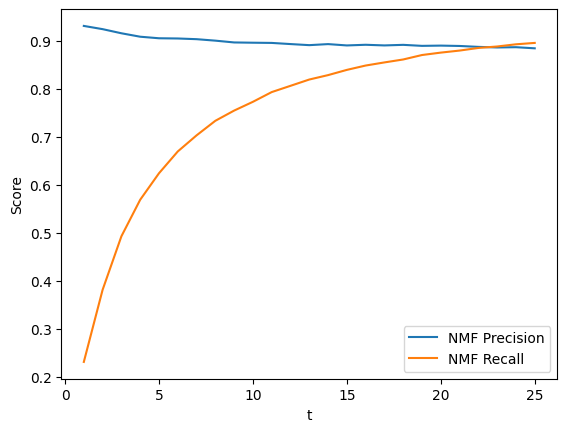

Processing SVD
t=1: Avg Precision=0.9345135717837909, Avg Recall=0.22515682700314596
t=2: Avg Precision=0.9287860077306703, Avg Recall=0.37135404400691885
t=3: Avg Precision=0.924343137639356, Avg Recall=0.47736740696397667
t=4: Avg Precision=0.9178431059563998, Avg Recall=0.5458393030984197
t=5: Avg Precision=0.9148134561643895, Avg Recall=0.6013511069934403
t=6: Avg Precision=0.9100872825785435, Avg Recall=0.6432184925102103
t=7: Avg Precision=0.9113505659614376, Avg Recall=0.6760218489687511
t=8: Avg Precision=0.9082988036480686, Avg Recall=0.697086951792086
t=9: Avg Precision=0.9076012176301441, Avg Recall=0.720807278056505
t=10: Avg Precision=0.9068149498076986, Avg Recall=0.7405363122651558
t=11: Avg Precision=0.9035423085966672, Avg Recall=0.7558750285918955
t=12: Avg Precision=0.9018127224054847, Avg Recall=0.7704980569971152
t=13: Avg Precision=0.9014421787337928, Avg Recall=0.7822364328948056
t=14: Avg Precision=0.8997211068580091, Avg Recall=0.7918930293774127
t=15: Avg Prec

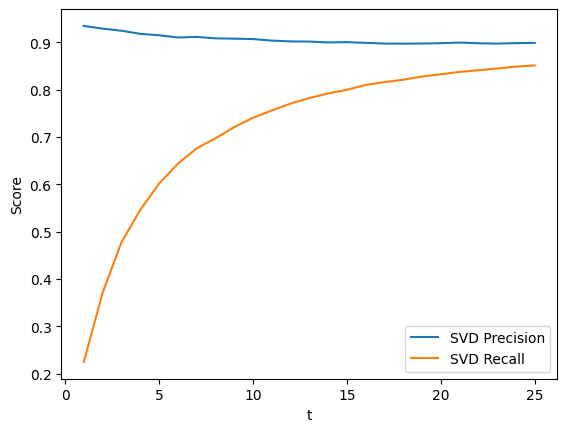

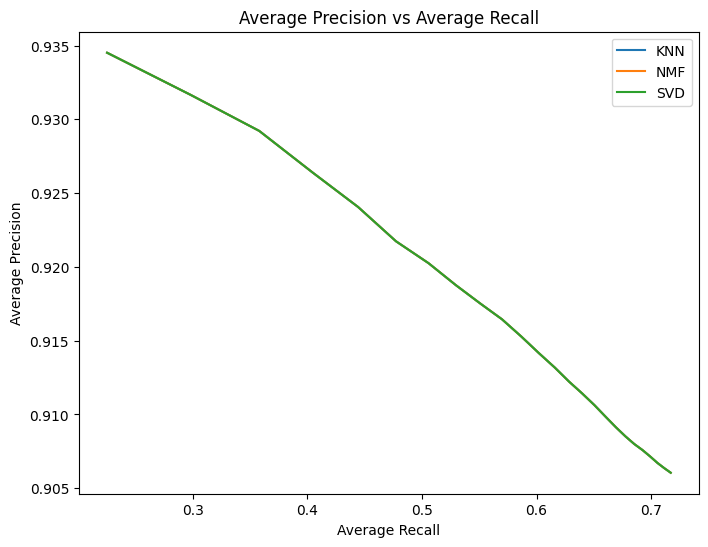

In [13]:
from collections import defaultdict
from sklearn.metrics import precision_recall_curve, auc
from surprise import KNNBasic, NMF, SVD
from surprise.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

# Define models
models = {
    'KNN': KNNBasic(k=50),
    'NMF': NMF(n_factors=100),
    'SVD': SVD(n_factors=150)
}

kf = KFold(n_splits=10)

for name, model in models.items():
    print(f"Processing {name}")
    
    precision_list = []
    recall_list = []
    average_precision_list = []
    average_recall_list = []

    for t in range(1, 26):
        precision_values = []
        recall_values = []
        
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset)
            precisions, recalls = precision_recall_at_k(predictions, k=t, threshold=3)
            # Precision and recall are mappings user_id -> float value. You should take the average of these values.
            precision = sum(prec for prec in precisions.values()) / len(precisions)
            recall = sum(rec for rec in recalls.values()) / len(recalls)
            precision_values.append(precision)
            recall_values.append(recall)

        
        avg_precision = np.mean(precision_values)
        avg_recall = np.mean(recall_values)
        precision_list.append(avg_precision)
        recall_list.append(avg_recall)
        
        average_precision_list.append(np.mean(precision_list))
        average_recall_list.append(np.mean(recall_list))
        
        print(f"t={t}: Avg Precision={avg_precision}, Avg Recall={avg_recall}")
    
    plt.figure()
    plt.plot(range(1, 26), precision_list, label=f'{name} Precision')
    plt.plot(range(1, 26), recall_list, label=f'{name} Recall')
    plt.xlabel('t')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

# Initialize the combined plot outside the models loop
plt.figure(figsize=(8, 6))
for name, model in models.items():
    plt.plot(average_recall_list, average_precision_list, label=f'{name}')
plt.xlabel('Average Recall')
plt.ylabel('Average Precision')
plt.title('Average Precision vs Average Recall')
plt.legend()
plt.show()

